**Auswertung:**

- Hier nur regelbasiertes Training
- 151 ist mit einem Agenten, dessen Aausgaben an alle Räume gesendet werden;
  152 mit einem Agent pro Raum
- Lernen mit einem einzigen Agenten für zu sauberen Q-Werten, nur ab und zu ausreiser ... wieso? das ist unklar
- Im Multi-Agenten-Ansatz werden die Q-Werte sehr unscharf gelernt, siehe letzte Grafik
- um 50 % längeres Training (S152longer) hat keinen, wirklich keinen Vorteil gebracht
- Vermutlich benötigt man im Multi-Agenten-Ansatz am Ende einen höhere Lernrate, um Q-Wert-Konvergenz zu erreichen?

In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [3]:
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

In [5]:
fig_width = 16

In [6]:
dirnames = ["../checkpoints/s151/20210515-1750/",
            "../checkpoints/s152/20210515-1751/",
            "../checkpoints/s152_longer/20210515-1754/"]

In [7]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [8]:
q_values = vh.load_and_convert_q_values(dirnames)

In [9]:
vh.get_arguments_overview(dirnames)

,s151,s152,s152_longer
reward_scale,0.3,0.055,0.055
epsilon_final_step,22500,22500,31500
model,Building_5ZoneAirCooled_SingleSetpoint_SingleA...,Building_5ZoneAirCooled_SingleSetpoint,Building_5ZoneAirCooled_SingleSetpoint


In [10]:
vh.get_runtime_overview_df(alldfs, dirnames)

,s151,s152,s152_longer
Number of training episodes,22500.000000,22500.000000,31500.000000
Runtime in s,28464.535069,34980.427820,49191.133285
Runtime in h,7.906815,9.716786,13.664204
Mean episode runtime in s,1.265090,1.554686,1.561623
Mean episode runtime during eval. episode in s,1.369796,1.691677,1.705673
Mean episode runtime after eval. episode in s,4.517871,5.085919,5.040162
Mean episode runtime in no eval. episode in s,1.264388,1.553766,1.560657


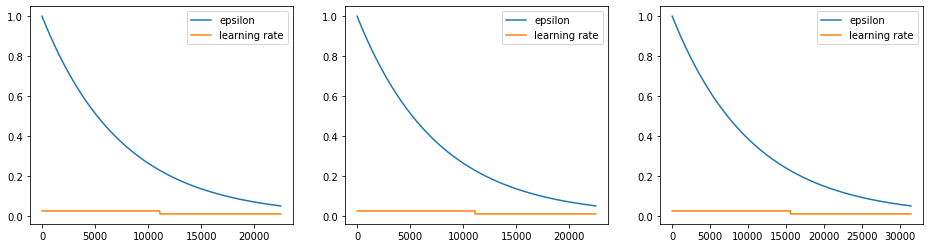

In [11]:
p, _ = vh.complete_plot_epsilon(alldfs, fig_width)
p.show()

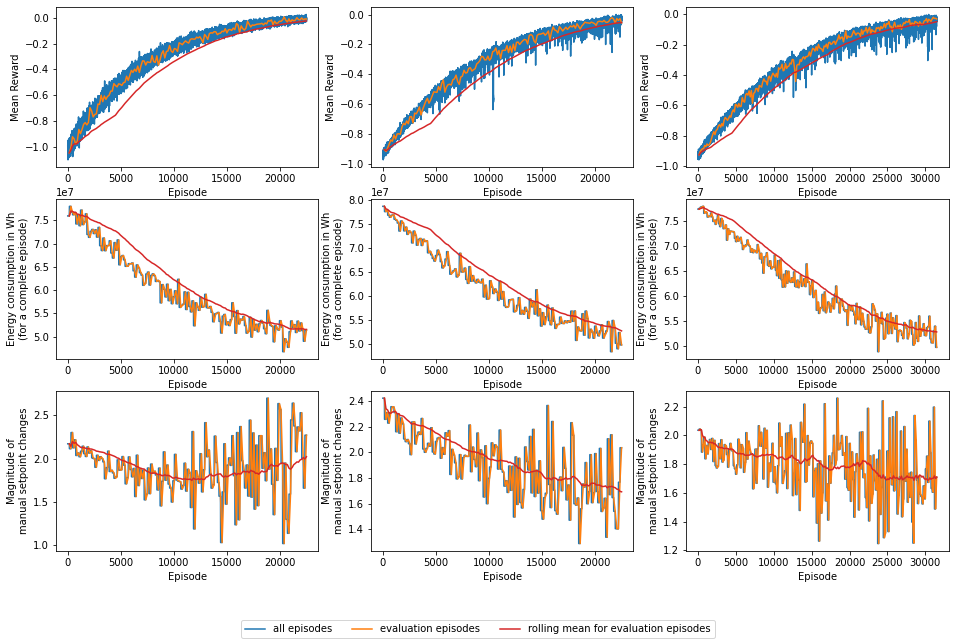

In [12]:
p, _ = vh.complete_plot_reward_stpc_econs(alldfs, fig_width)
p.show()

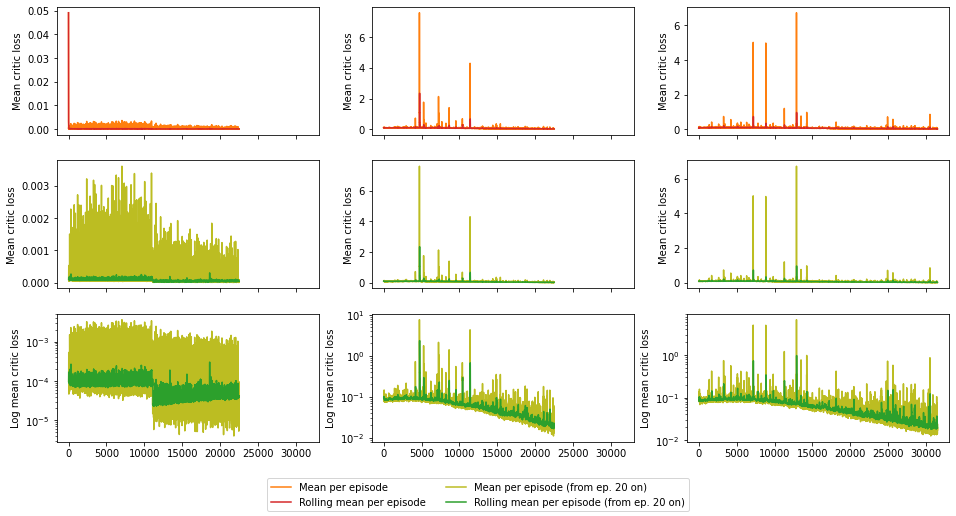

In [13]:
p, _ = vh.complete_plot_losses(alldfs, fig_width, with_agents=False)
p.show()

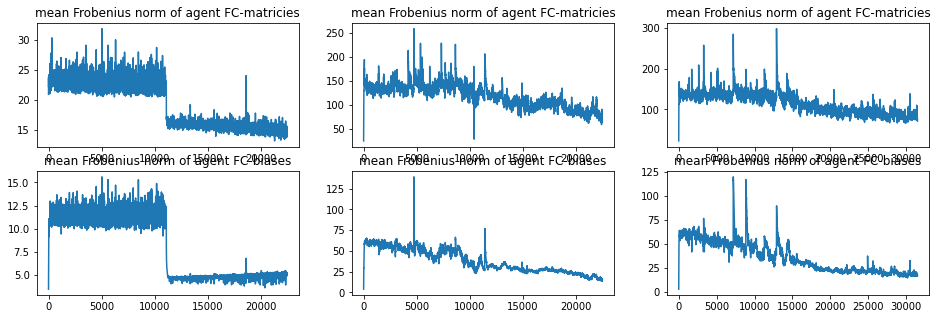

In [14]:
p, _ = vh.complete_plot_frobenius_norms(alldfs, fig_width, with_critics=False)
p.show()

In [15]:
last_available_eval_episodes = vh.compute_last_available_eval_episode(alldfs)

Last available evaluation episode for dfs0:  22499
Last available evaluation episode for dfs1:  22499
Last available evaluation episode for dfs2:  31499


<h3>Details for one week</h3>

In [16]:
#selected_episodes = [13120 - 1, 14480 - 1, 14480 - 1]
#selected_weeks    = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1)]

In [17]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = vh.select_week_and_episode_for_dfs_list(alldfs, selected_episodes, selected_weeks)

In [18]:
vh.print_reward_informations(subdfs, selected_episodes)

First complete week of evaluation episode
For episode 22499: Energy consumption:   51373.49 kWh; Numer of setpoint changes: 1632.9434208578218
For episode 22499: Energy consumption:   49726.30 kWh; Numer of setpoint changes: 1463.4103683814662
For episode 31499: Energy consumption:   49697.67 kWh; Numer of setpoint changes: 1228.9373320029301

Mean values for episode ...
... 22499: Reward: -0.00862 kWh; Setpoint change magnit.:  2.27113; Energy cons.: 71451.30703
... 22499: Reward: -0.05564 kWh; Setpoint change magnit.:  2.03534; Energy cons.: 69160.36771
... 31499: Reward: -0.03021 kWh; Setpoint change magnit.:  1.70923; Energy cons.: 69120.54626


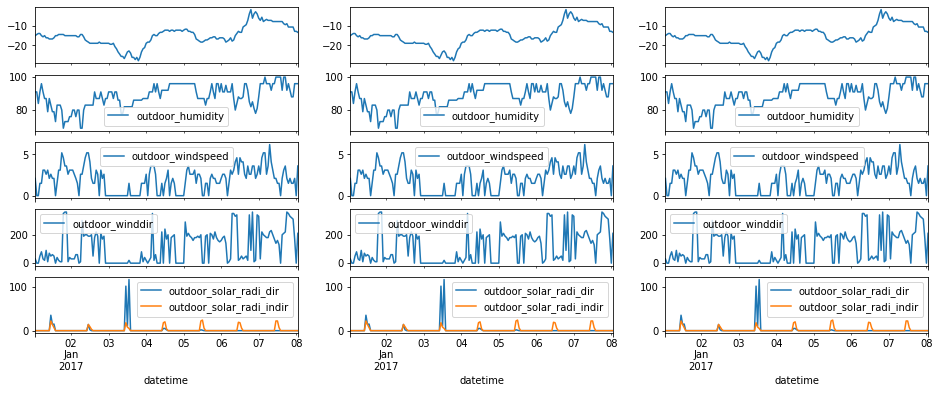

In [19]:
p, _ = vh.complete_plot_weather_information(subdfs, fig_width)
p.show()

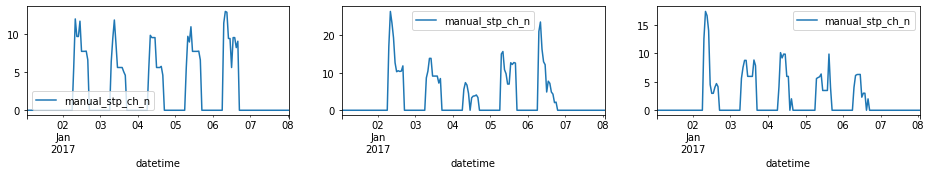

In [20]:
p, _ = vh.complete_plot_number_of_stp_ch(subdfs, fig_width)
p.show()

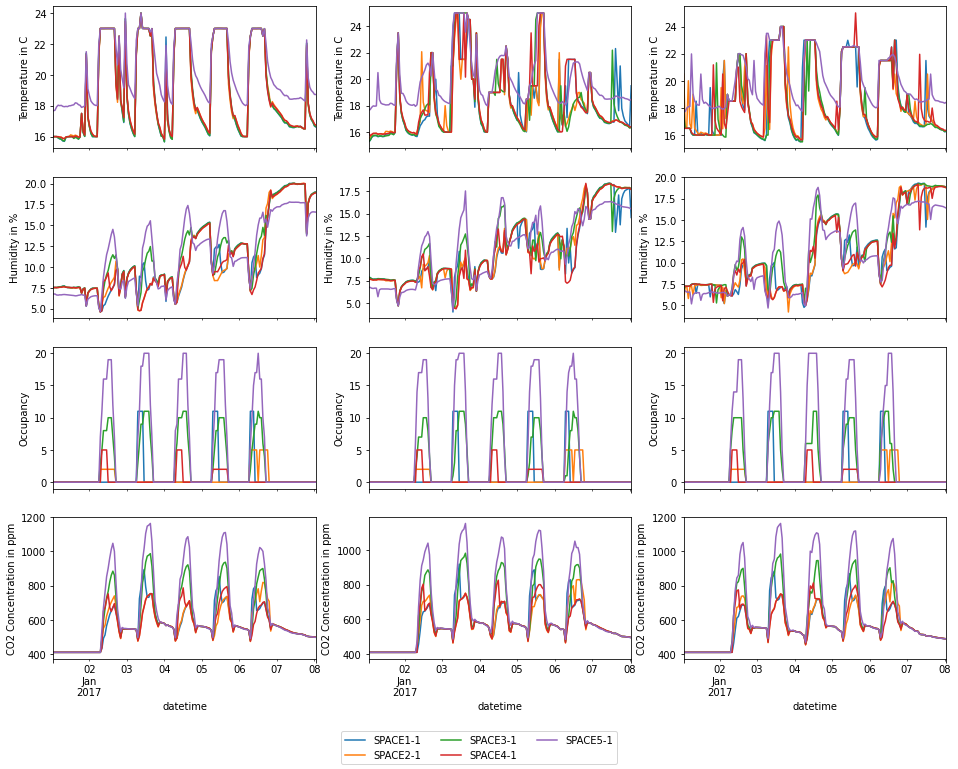

In [21]:
p, _ = vh.complete_plot_room_status(subdfs, fig_width)
p.show()

In [22]:
subdfs_rooms, subdfs_agents = vh.get_available_rooms_and_agents(subdfs)

Available Rooms     in (sub-)dfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs0: [0] 

Available Rooms     in (sub-)dfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs1: [0 1 2 3 4] 

Available Rooms     in (sub-)dfs2: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs2: [0 1 2 3 4] 



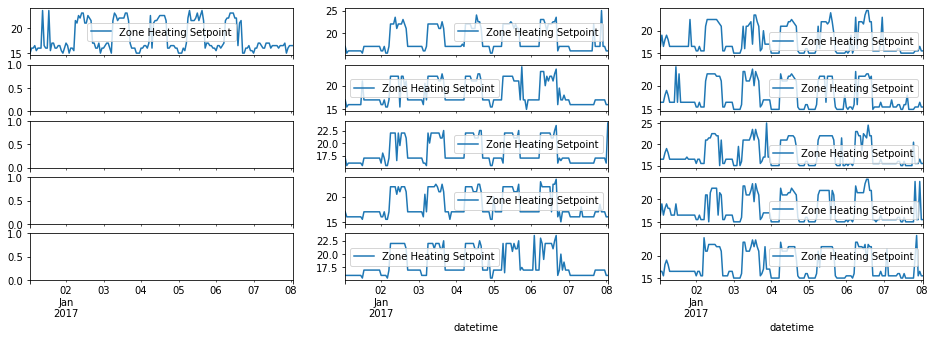

In [23]:
p, _ = vh.complete_plot_all_agent_outputs(subdfs, fig_width, subdfs_agents)
p.show()

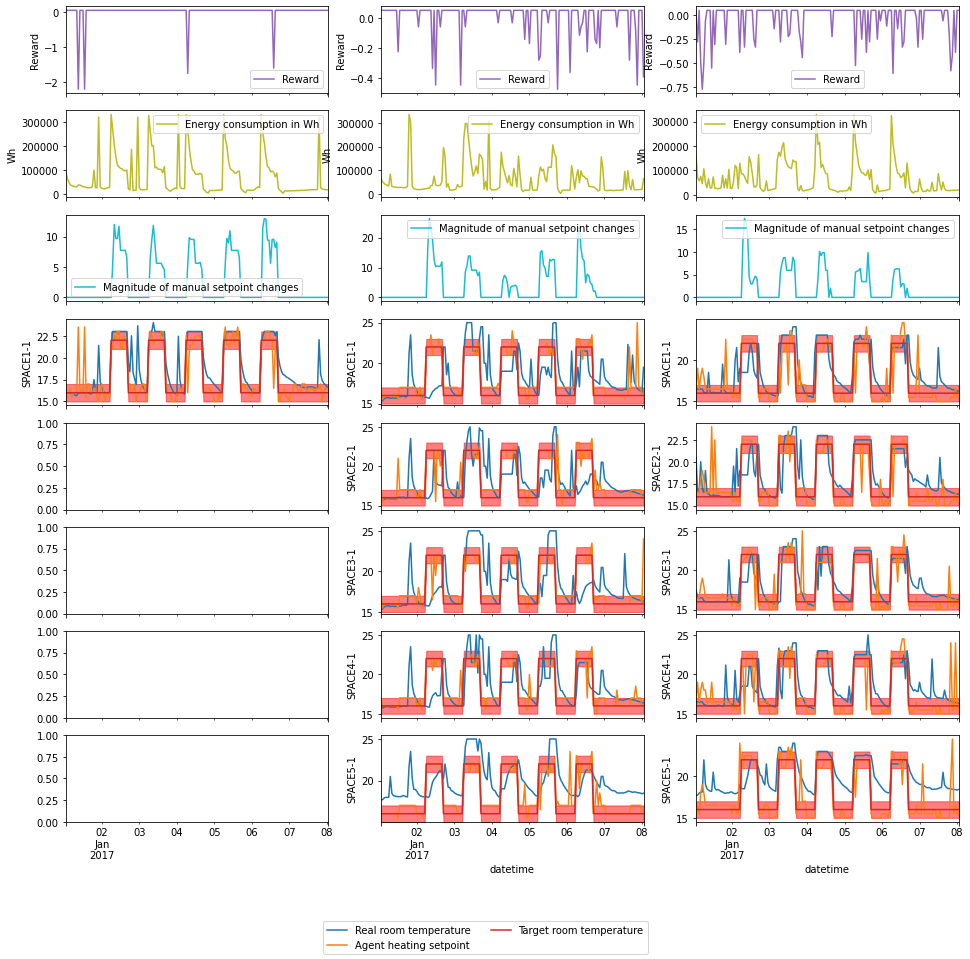

In [24]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a day</h3>

In [25]:
#selected_periods1    = [datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3)]
#selected_periods1_end= [datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4)]

In [26]:
if not "selected_periods1" in locals().keys():
    selected_periods1     = [datetime.datetime(2017, 1, 3) for _ in range(len(alldfs))]
if not "selected_periods1_end" in locals().keys():
    selected_periods1_end = [datetime.datetime(2017, 1, 4) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods1,
            selected_periods1_end)

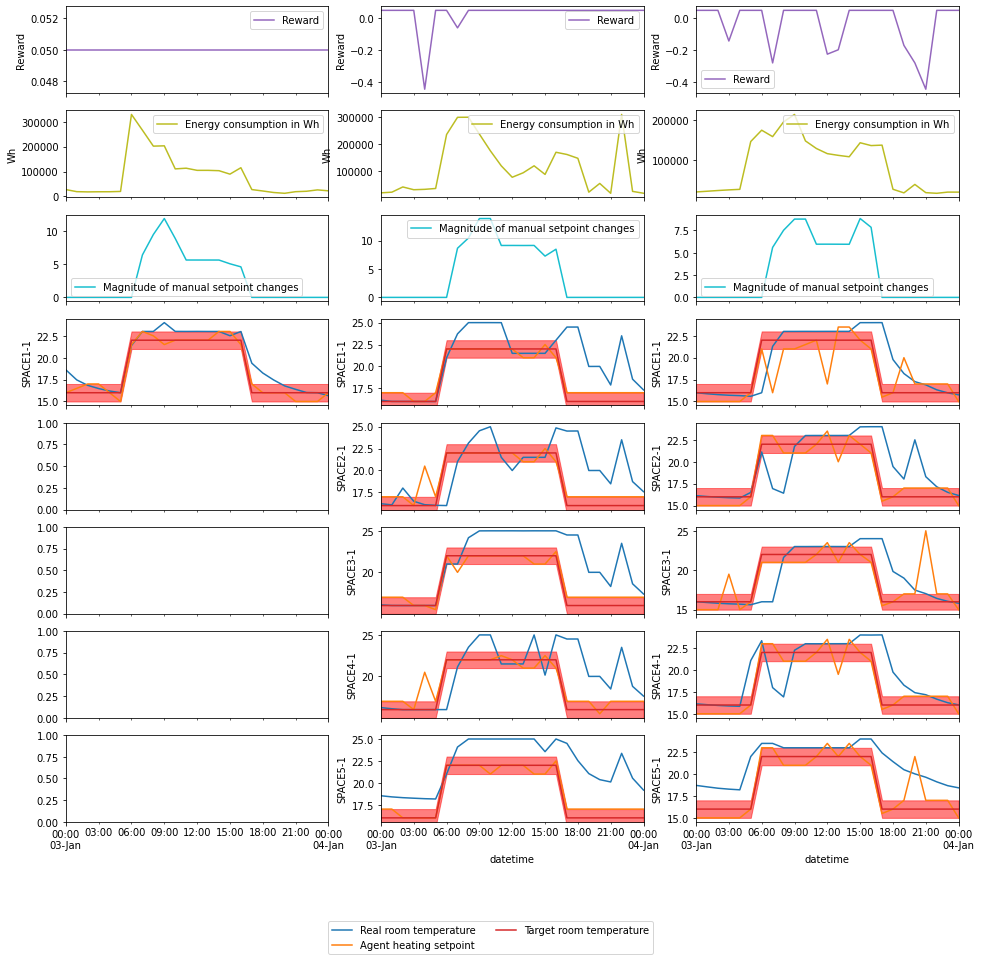

In [27]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a complete month</h3>

In [28]:
#selected_periods2    = [datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1)]

In [29]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods2,
            selected_periods2_end)

For plot number 1, mean energy consumption =  70269.3 Wh, mean reward = -0.0106
For plot number 2, mean energy consumption =  68157.9 Wh, mean reward = -0.0457
For plot number 3, mean energy consumption =  68285.2 Wh, mean reward = -0.0310


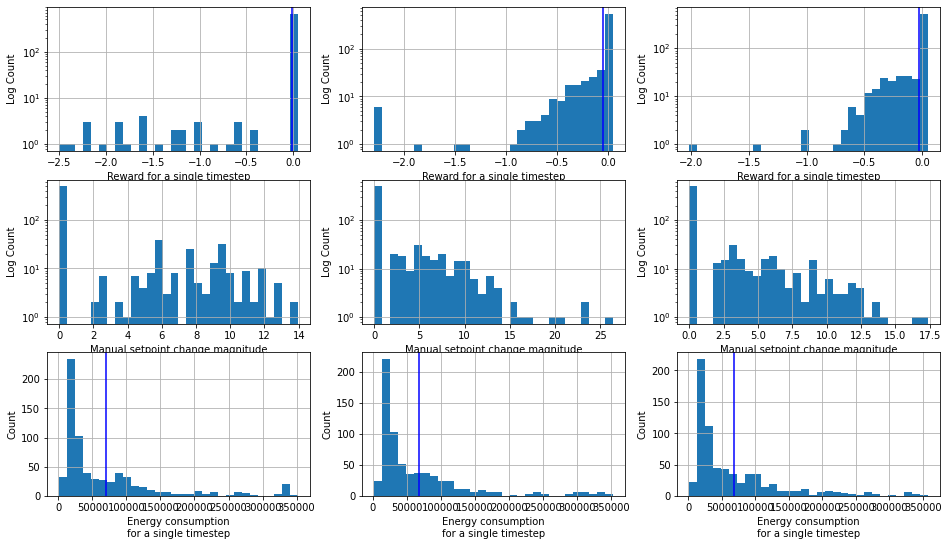

In [30]:
vh.plot_stpch_and_econs_distrib(subdfs, fig_width)

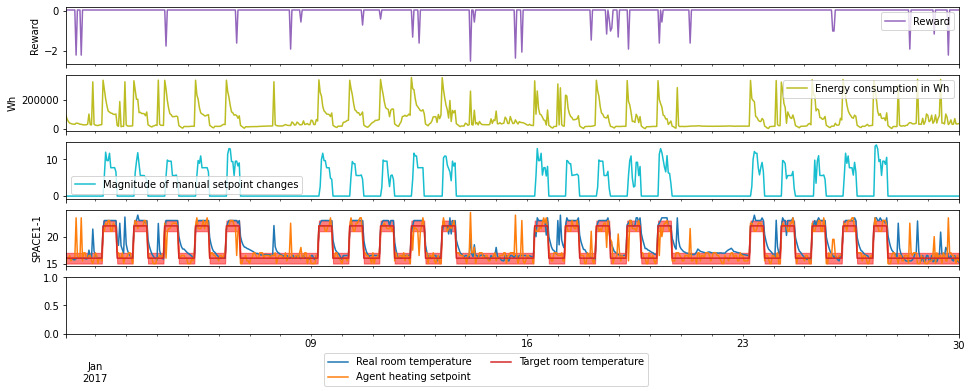

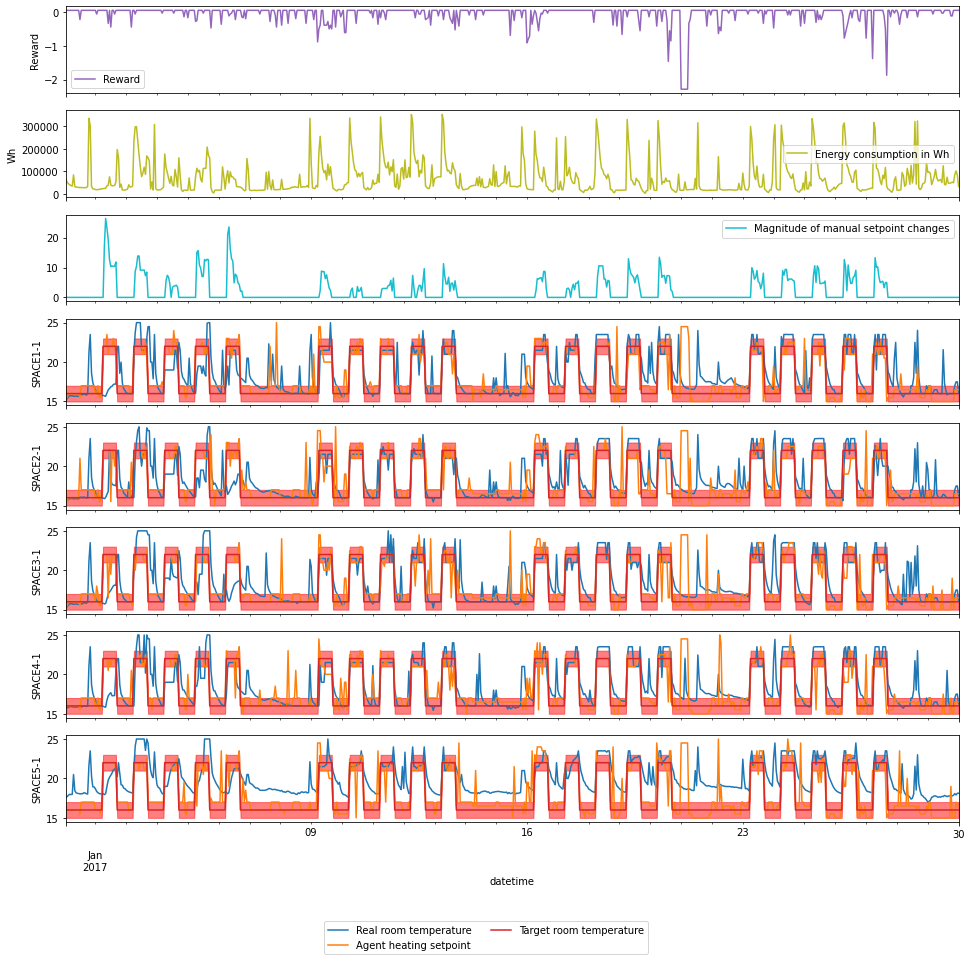

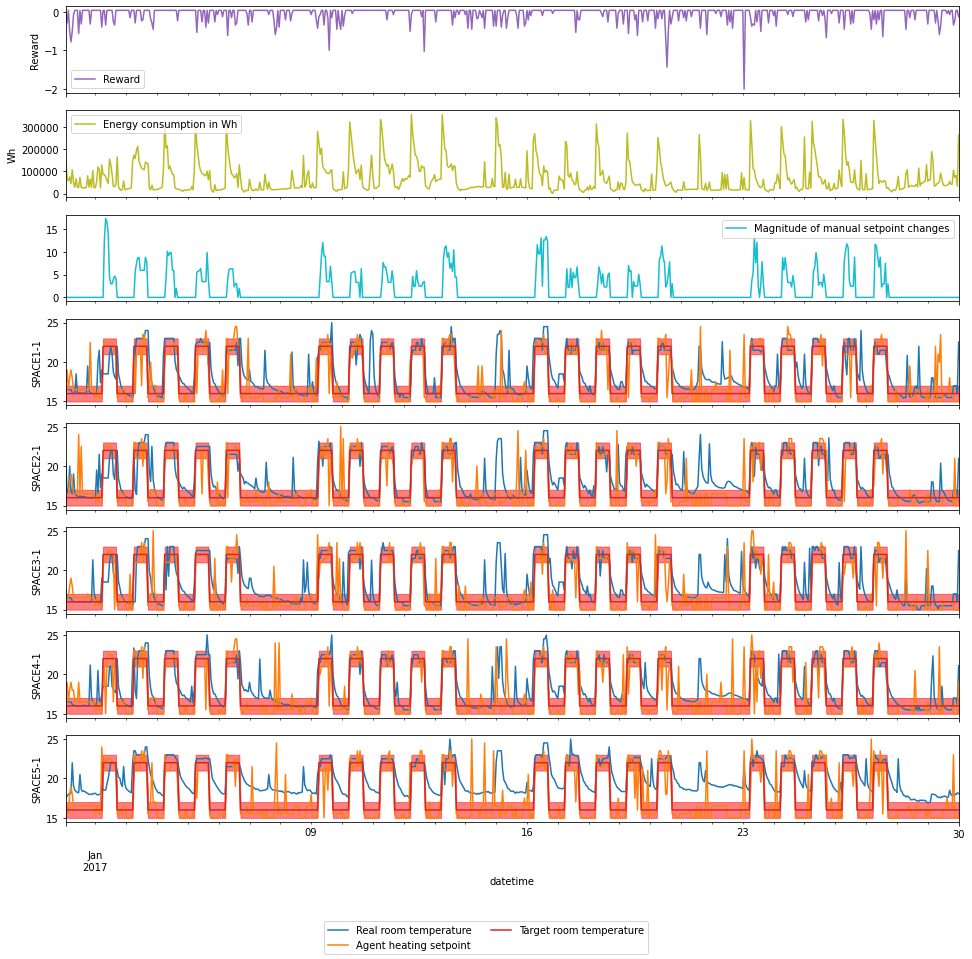

In [31]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()

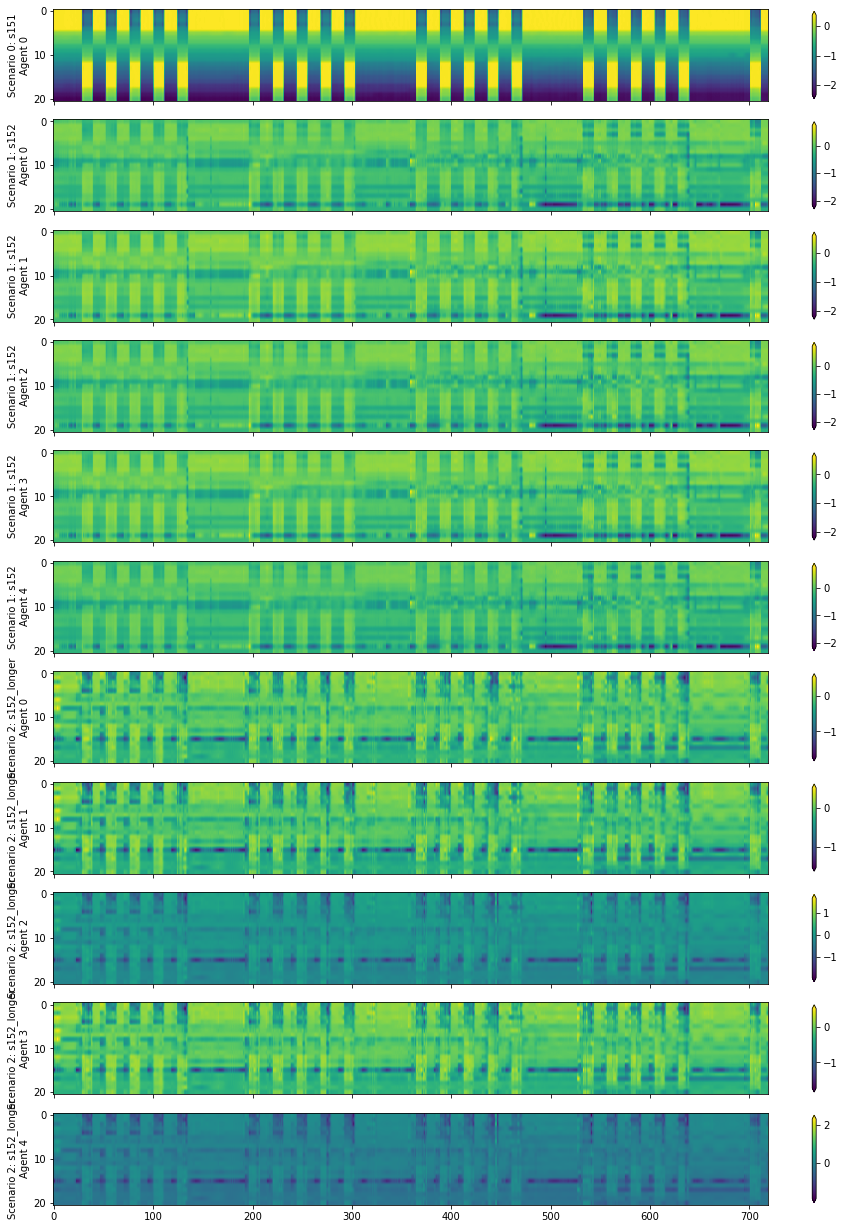

In [32]:
vh.plot_q_values(q_values, fig_width)